In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import torch
from greedy_models.tree_glm import Tree_GLM

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
sub_no = 10
E_no = E_neural.shape[1]
I_no = I_neural.shape[1]
device = torch.device("cuda")

batch_size = 15000
iter_no = 9990
epoch_no = iter_no*batch_size//T_train 
print(epoch_no)

3


In [4]:
V_train = V[:T_train].to(device)
V_test = V[T_train:T_train + T_test].to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

In [5]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Tree_GLM(sub_no, E_no, I_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

32110


In [7]:
temp_list = np.logspace(0,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    temp = temp_list[temp_count]
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    batch_pred, out_filters, C_den, C_syn_e, C_syn_i = model(batch_E_neural,
                                                            batch_I_neural, temp, False)
    loss = torch.var(batch_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_V_pred, test_out_filters, test_C_den, test_C_syn_e, test_C_syn_i = model(test_E_neural,
                                                            test_I_neural, 0, True)
            
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        print(i, test_score)

<ipython-input-7-21c4e0959a73>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.029246029990951494
100 0.28755812704527817
200 0.2269664000240602
300 0.39470370878950267
400 0.2539805636889917
500 0.3085801709959326
600 0.16108409212409058
700 0.4261068867749981
800 0.5225995042652751
900 0.5957396690516448
1000 0.6925348277851506
1100 0.7022510089189165
1200 0.804233043398223
1300 0.8165472672308891
1400 0.8960614456437037
1500 0.9067176224160312
1600 0.9219927004667678
1700 0.8983486030904695
1800 0.9212749486107863
1900 0.9360485509815974
2000 0.9416624347564387
2100 0.9435112839789446
2200 0.9371713095254429
2300 0.9434584029010722
2400 0.9424780461623584
2500 0.9426658457852023
2700 0.9430844586174972
2800 0.9390829603620043
2900 0.9417721727145979
3000 0.9472599215248196
3100 0.9500538533241343
3200 0.9457289319474579
3300 0.9480694601402709



KeyboardInterrupt: 

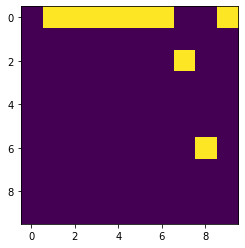

In [8]:
plt.imshow(test_C_den.cpu().detach().numpy())

In [12]:
print(model.C_den_raw.shape)

torch.Size([89])


In [8]:
print(C_den)

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<CopySlices>)


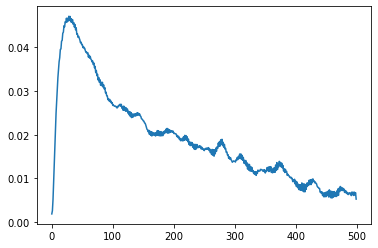

In [23]:
plt.plot(test_out_filters[9].cpu().detach().numpy())

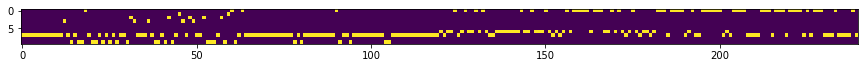

In [27]:
plt.figure(figsize=(15,5))
plt.imshow(C_syn_e[:,880:1120].cpu().detach().numpy())